# PySpark. Window Functions . My code from Zeppelin notebook.

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events").where("date < '2019-11-02'")
events_df.show(5)

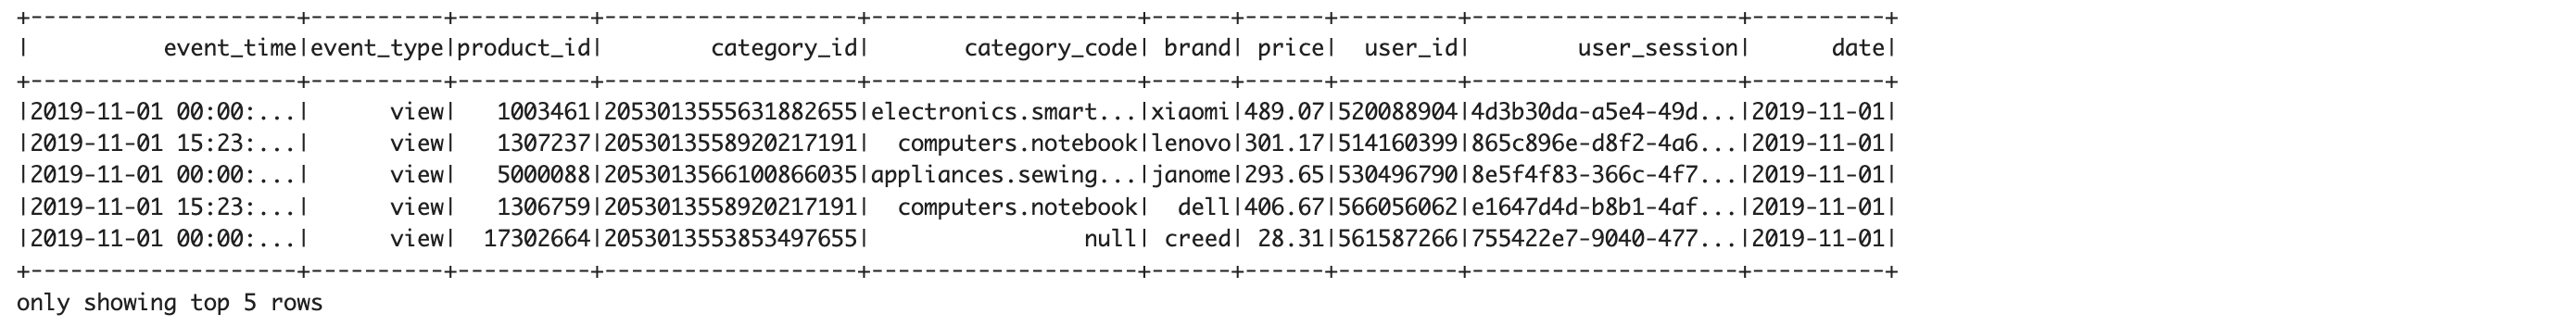

### The 'category_code' column has three levels. It was necessary to separate them into different columns.

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_new_df = events_df \
    .withColumn("cat_array", f.split("category_code", "\.")) \
    .withColumn("categori_1", f.col("cat_array")[0]) \
    .withColumn("categori_2", f.col("cat_array")[1]) \
    .withColumn("categori_3", f.col("cat_array")[2]) \
    .drop("cat_array")

events_new_df \
.show(5)

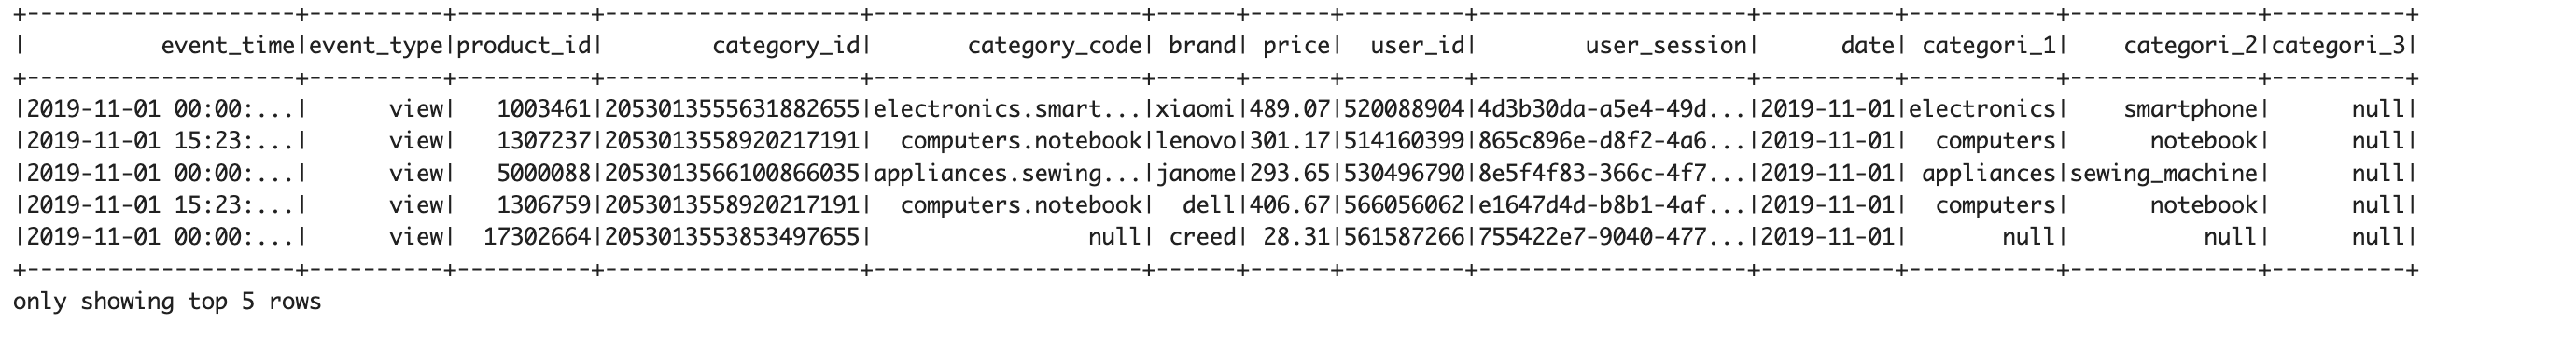

### Display the top 3 brands by the number of views for each category of the 2nd level

In [ ]:
%pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as f

windowSpec  = Window.partitionBy("categori_2").orderBy(f.col('view_count').desc())
events_new_df \
    .groupBy("categori_2", "brand") \
    .agg(
        f.count("event_type").alias("view_count")
        ) \
    .withColumn("row_number", f.row_number().over(windowSpec)) \
    .filter(f.col("row_number") <= 3) \
    .show(10)

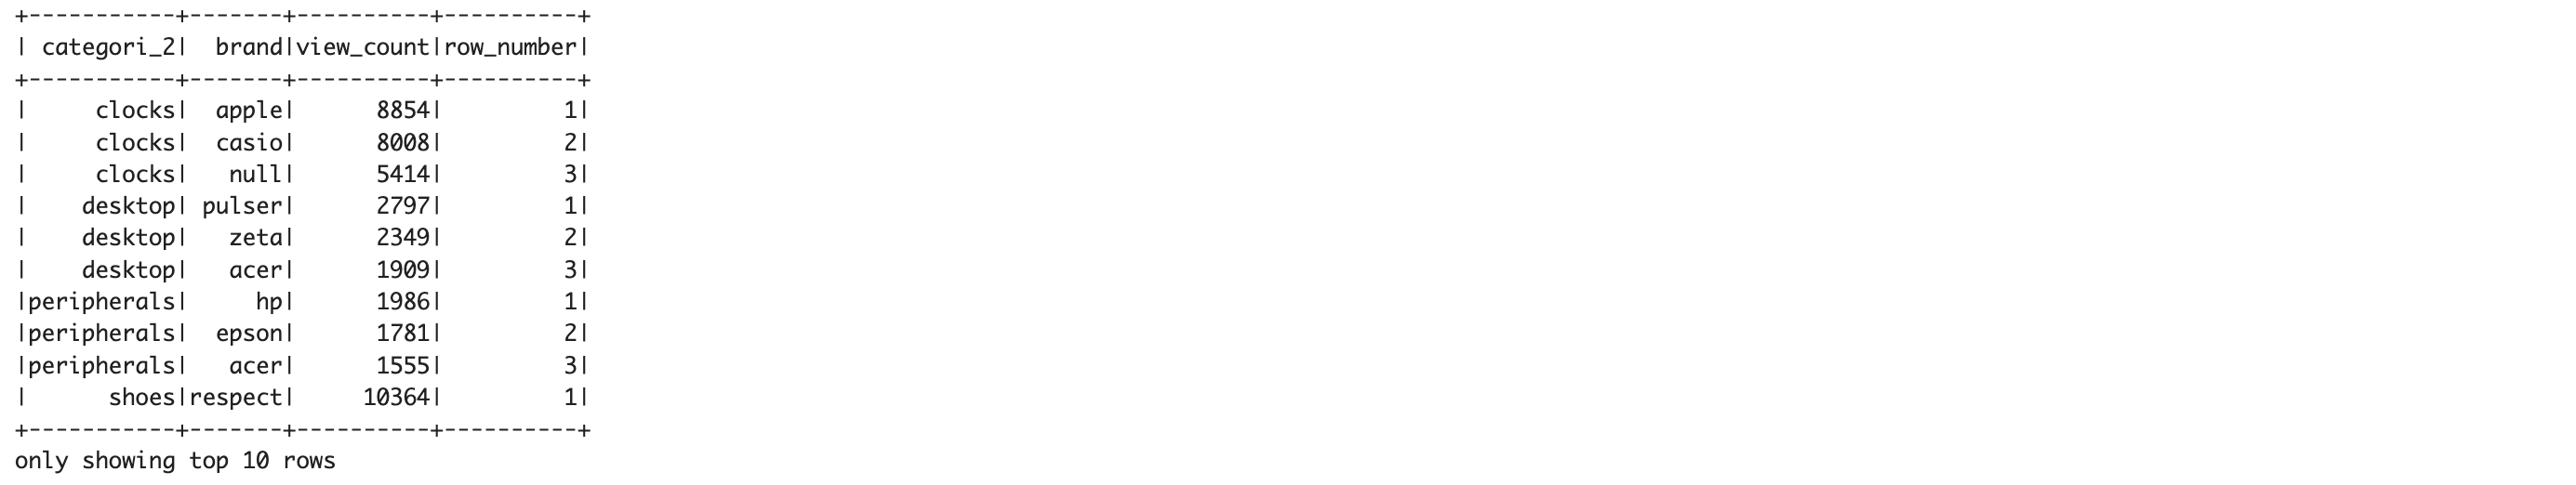

# Music Chart. 

In [ ]:
%pyspark

tracks = spark.table("chart.tracks")
tracks.show(10)

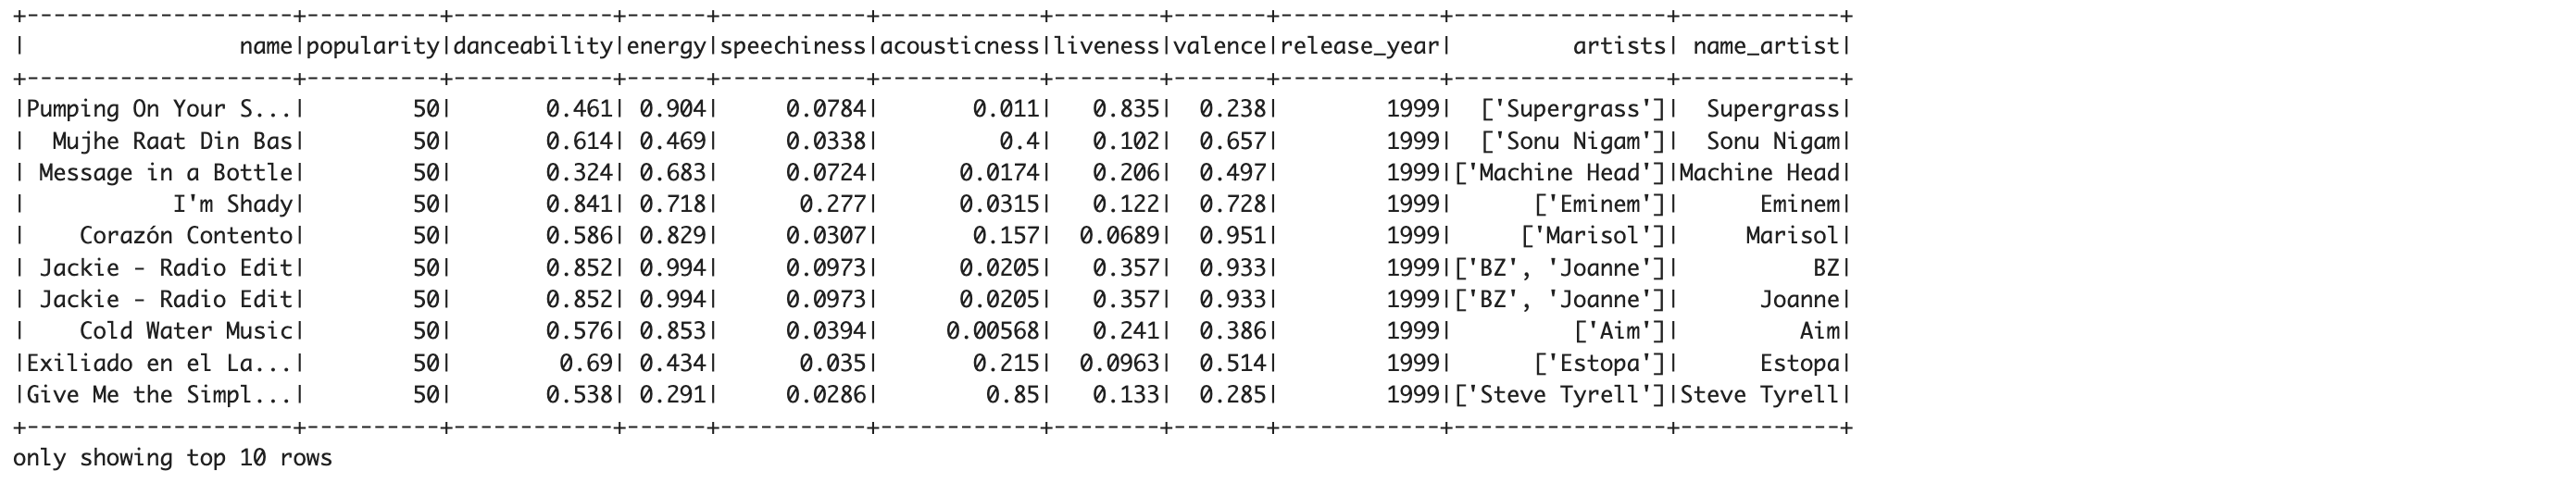

In [ ]:
%pyspark
import pyspark.sql.functions as f
tracks.select(f.min("release_year"), f.max("release_year")).show(truncate=False)
tracks.printSchema()

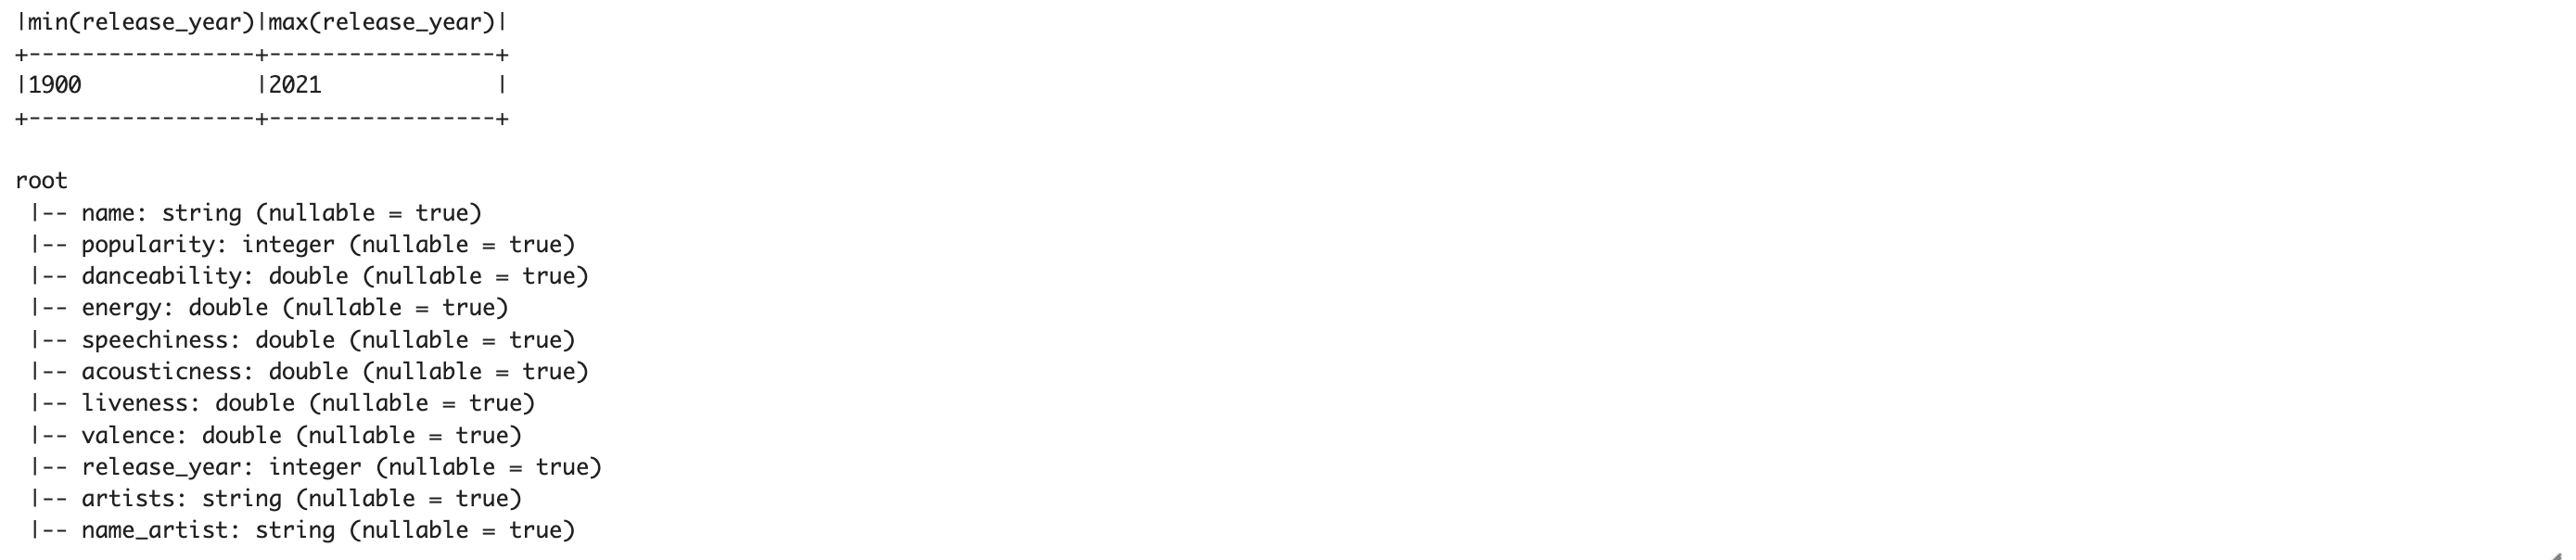

### Artists who have released the most songs from the annual top 100 (by popularity)?

In [ ]:
%pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as f

windowSpec  = Window.partitionBy("release_year").orderBy(f.col('popularity').desc())
tracks \
    .withColumn("row_number", f.row_number().over(windowSpec)) \
    .filter(f.col("row_number") <= 100) \
    .groupBy("name_artist") \
    .agg(
        f.count("*").alias("count")
        ) \
    .orderBy(f.col("count").desc()) \
    .show(10, truncate=False)

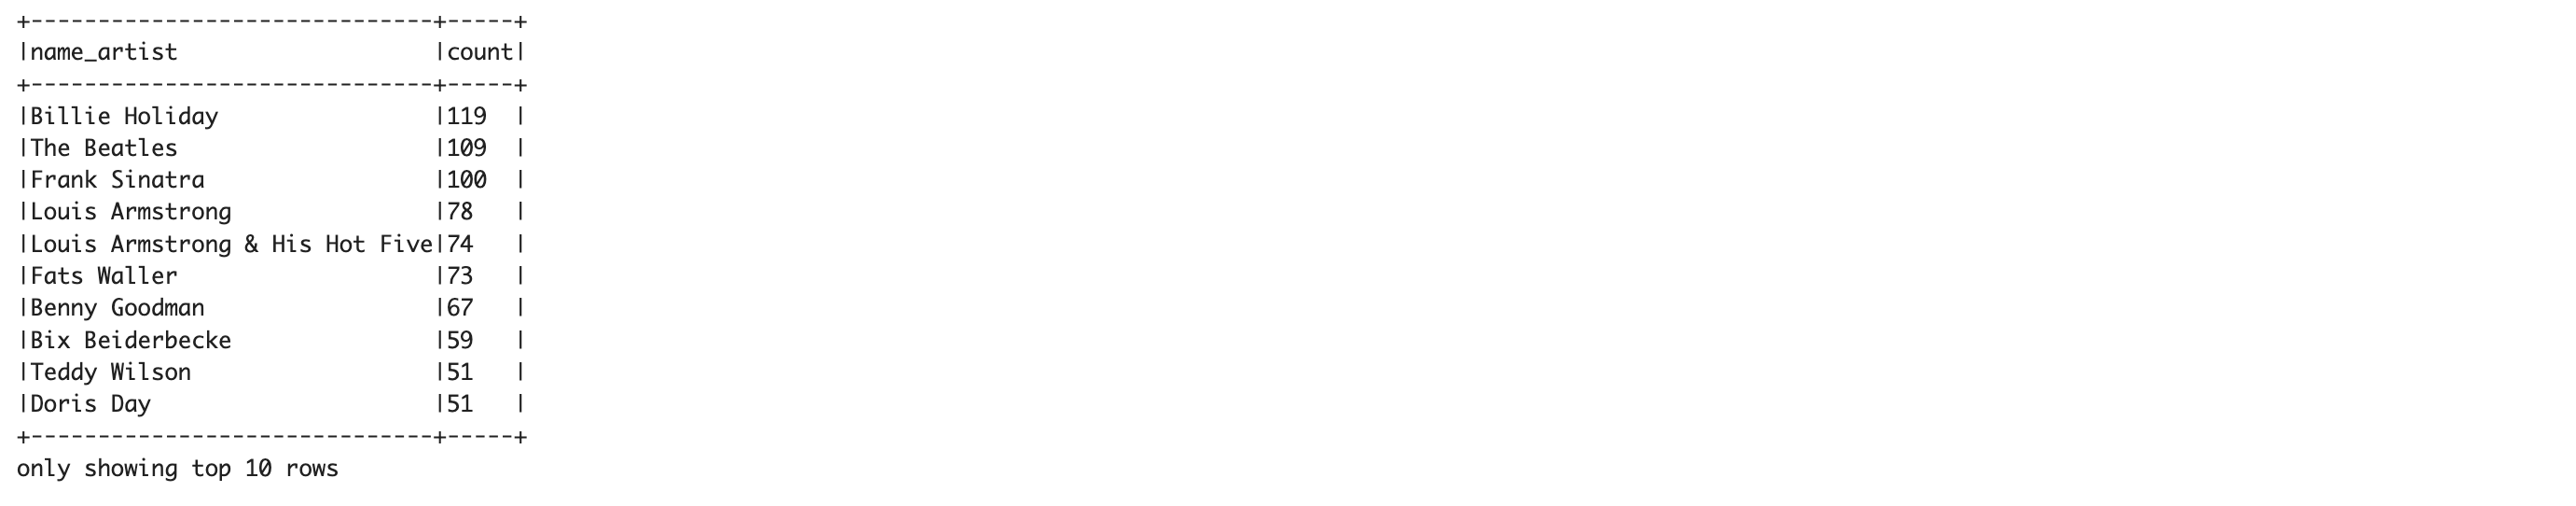

### Top artists who most often hit the annual top 100 songs by popularity.

In [ ]:
%pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as f

windowSpec  = Window.partitionBy("release_year").orderBy(f.col('popularity').desc())
tracks \
    .withColumn("row_number", f.row_number().over(windowSpec)) \
    .filter(f.col("row_number") <= 100) \
    .groupBy("name_artist") \
    .agg(
        f.countDistinct("release_year").alias("count_artist")
        ) \
    .orderBy(f.col("count_artist").desc()) \
    .show(10, truncate=False)

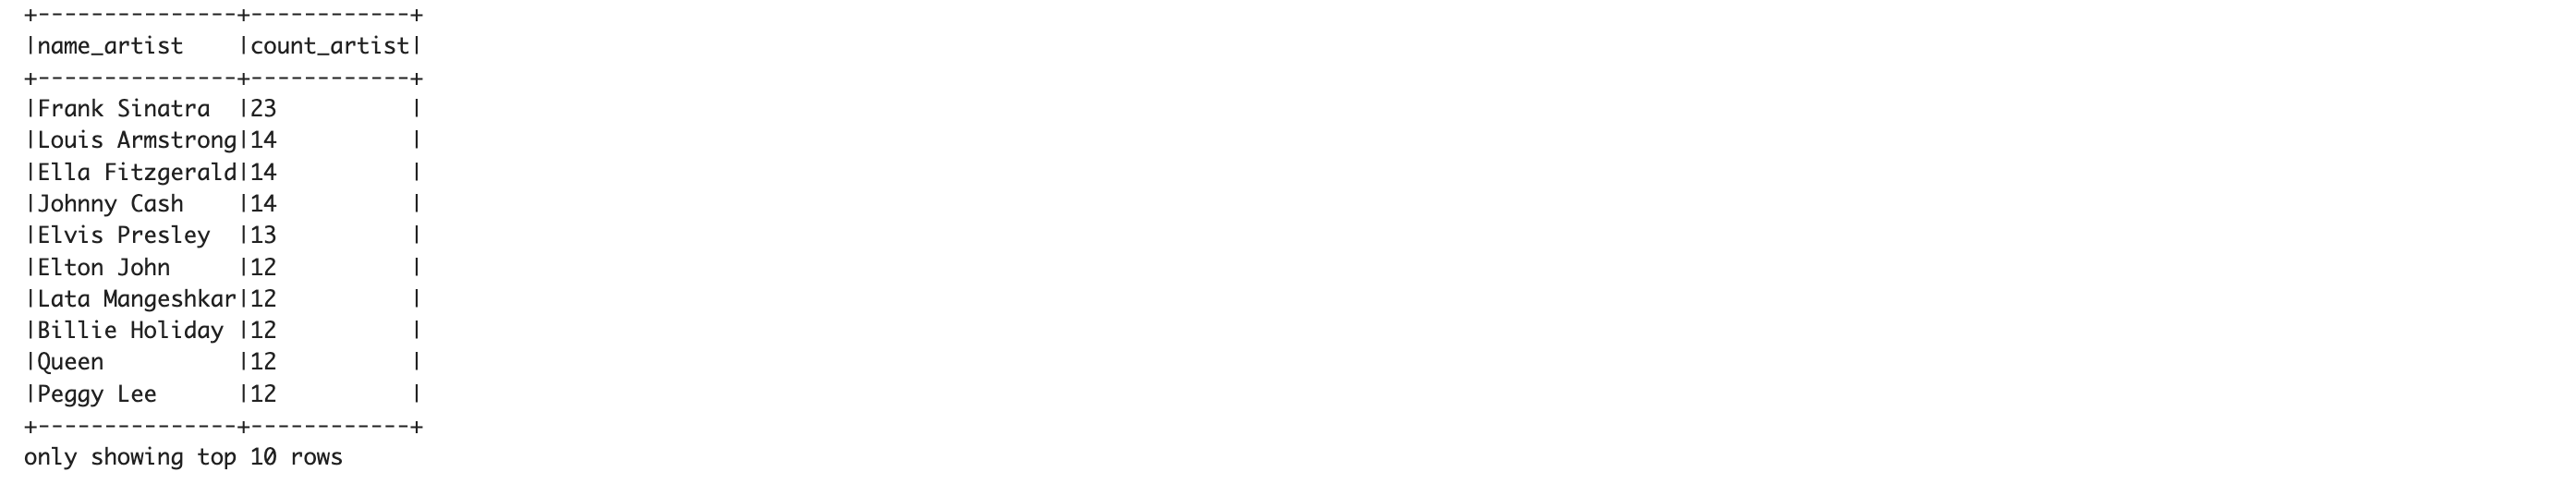

### Artists who have been on the annual top 100 most popular songs for several years in a row?

In [ ]:
%pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as f

windowSpec  = Window.partitionBy("release_year").orderBy(f.col('popularity').desc())
top_tracks = tracks \
    .withColumn("row_number", f.row_number().over(windowSpec)) \
    .filter(f.col("row_number") <= 100)

In [ ]:
%pyspark

windowSpec_2  = Window.partitionBy("name_artist").orderBy(f.col("release_year"))
top_tracks \
    .groupBy("name_artist", "release_year") \
    .agg(
        f.count("*").alias("count")
        ) \
    .withColumn("row_number", f.row_number().over(windowSpec_2)) \
    .withColumn("diff", (f.col("release_year") - f.col("row_number"))) \
    .groupBy("name_artist", "diff") \
    .agg(
        f.count("*").alias("count_diff")
        ) \
    .filter(f.col("count_diff") != 1) \
    .groupBy("name_artist") \
    .agg(
        f.sum("count_diff").alias("max_period")
        ) \
    .orderBy(f.col("max_period").desc()) \
    .show(10, truncate=False)

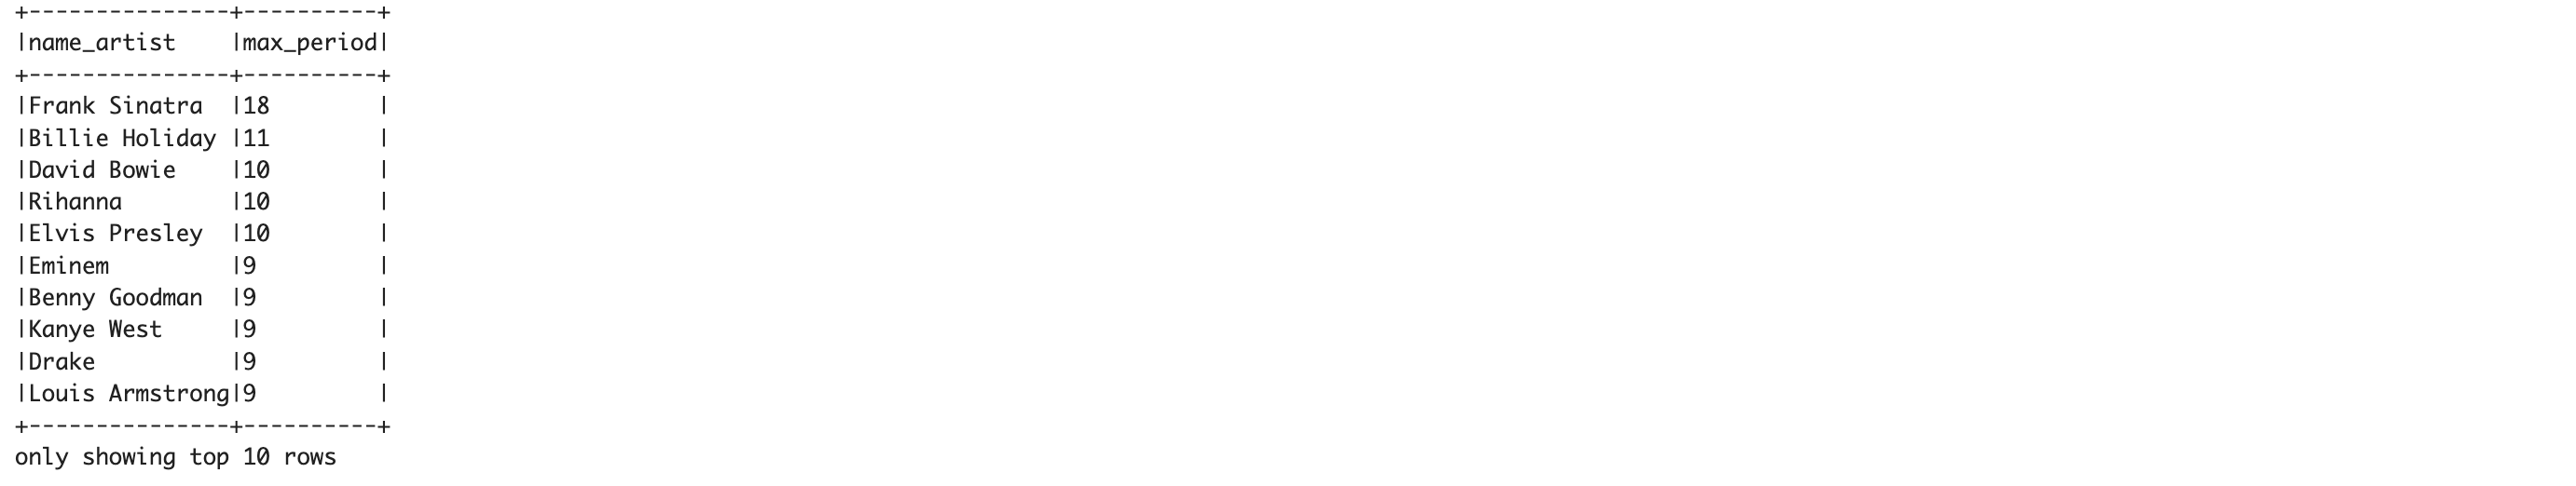

### For each audio feature, output the top 3 artists based on the average value of each audio feature of their songs. Optional: normalize to the average value of the audio characteristics in the year the songs were released.

In [ ]:
%pyspark
thislist = ["danceability", "acousticness", "energy", "speechiness", "liveness", "valence"] 
for x in thislist:
    avg_characteristic_year = tracks \
        .groupBy("release_year") \
        .agg(
            f.avg(x).alias("avg_year")
        ) \
        .orderBy(f.col("release_year")) 
    tracks \
        .join(avg_characteristic_year, on=['release_year'], how='left_outer') \
        .withColumn("norm_characteristic", (f.col(x) / f.col("avg_year"))) \
        .groupBy("name_artist") \
        .agg(
            f.avg("norm_characteristic").alias("norm_{}_mean".format(x))
        ) \
        .orderBy(f.col("norm_{}_mean".format(x)).desc()) \
        .show(3, truncate=False)

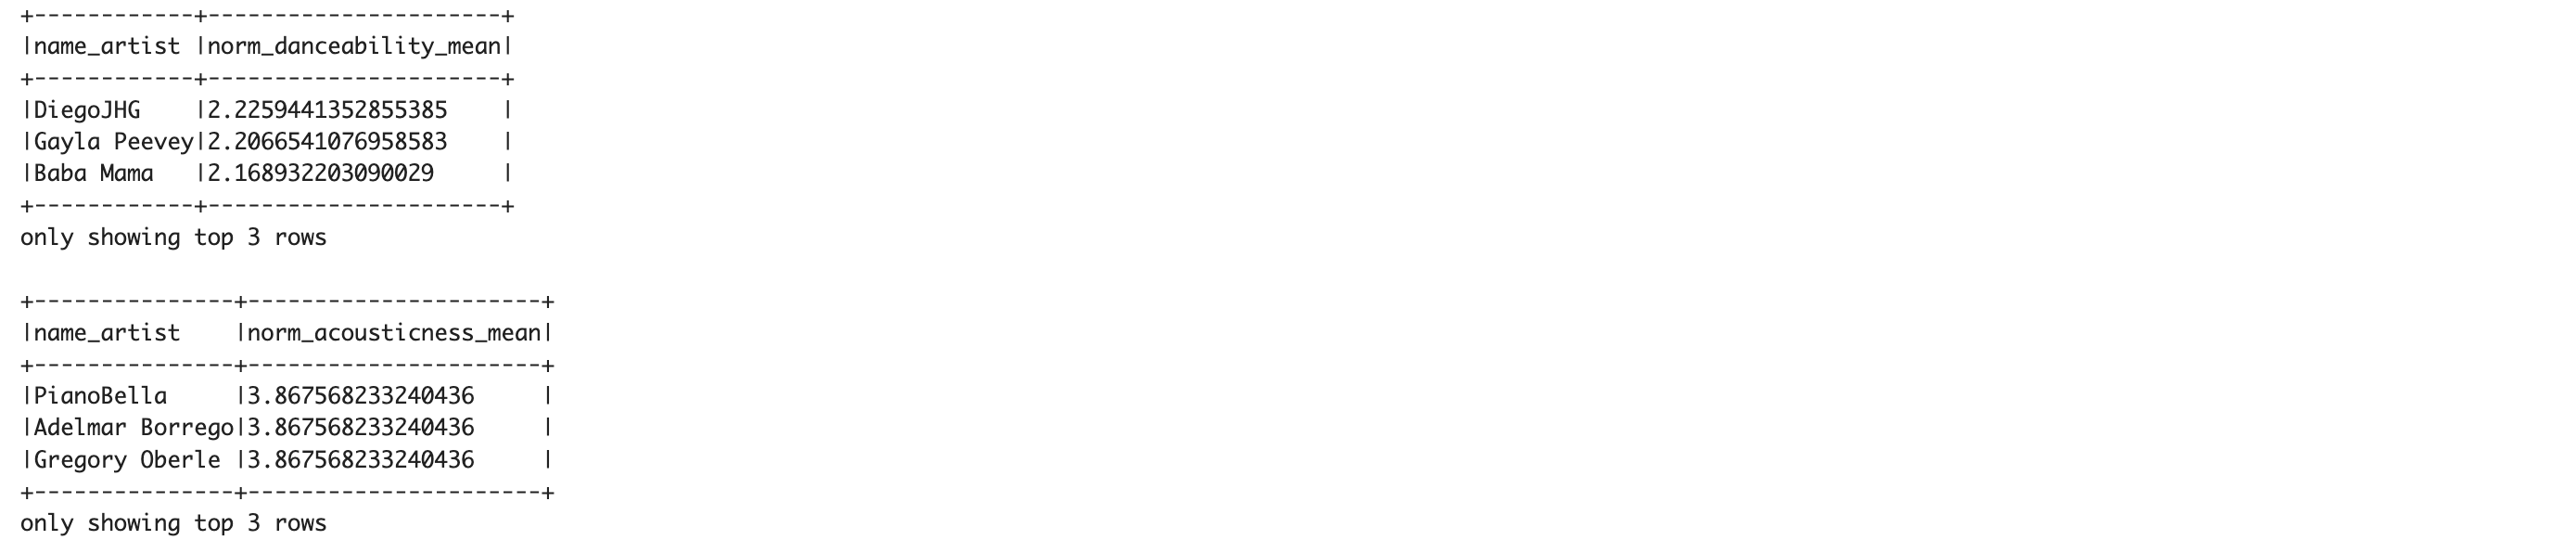

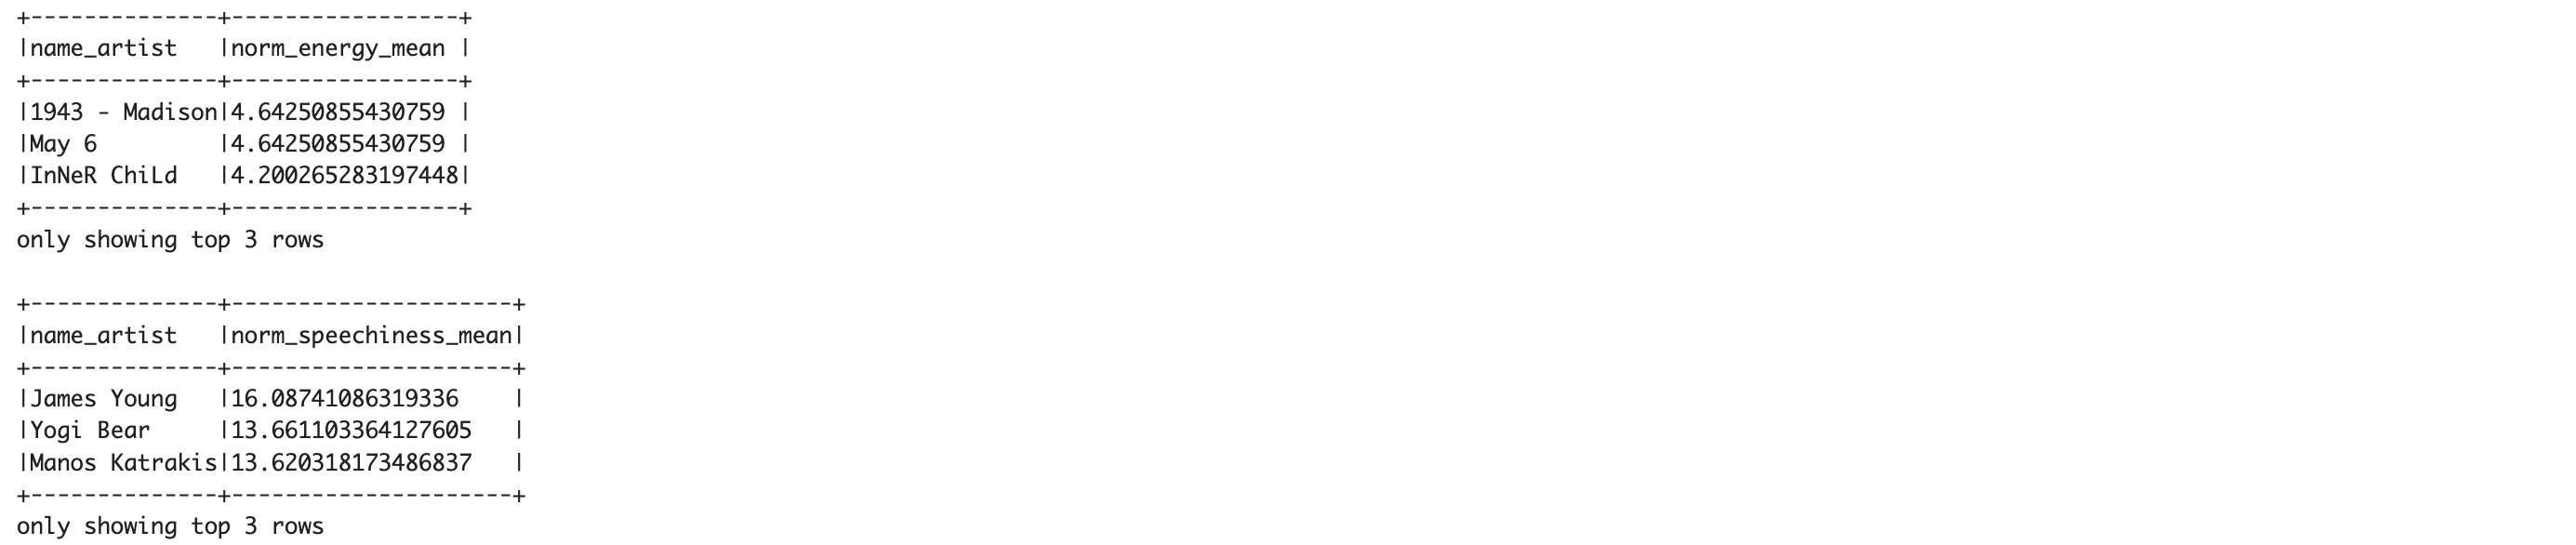

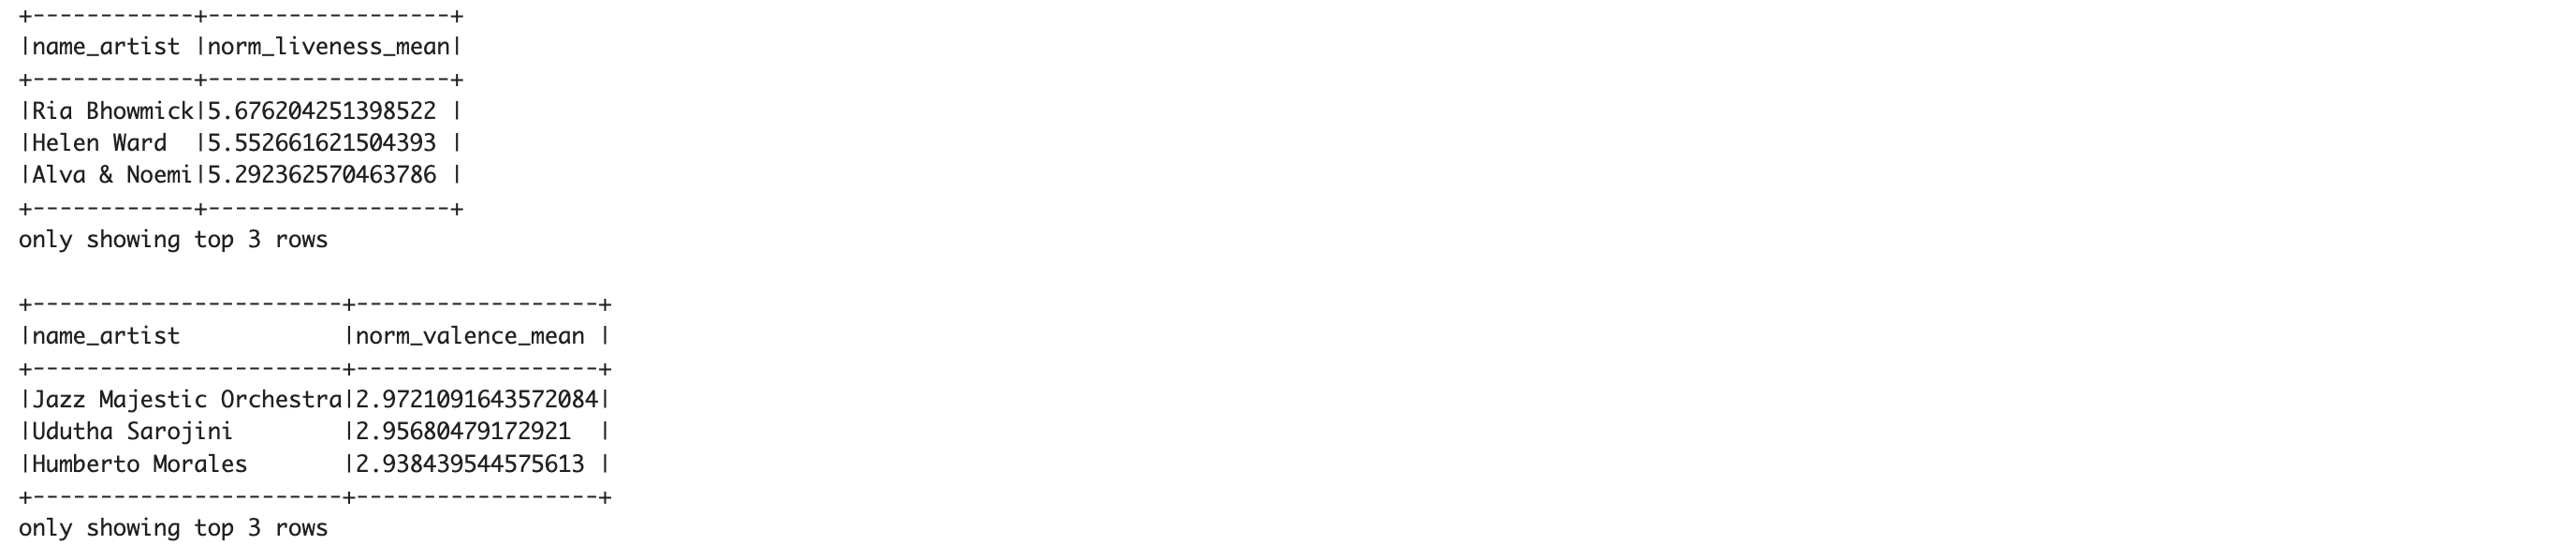